In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid
import pathlib
import shutil
import cv2
import os
import json
from PIL import Image
import image_to_numpy  # deal with image rotation issue automatically

from engine import train_one_epoch, evaluate
import utils

import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
class SugarcaneWeedsDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transforms=None):
        super().__init__()
        
        self.img_ids = list(sorted(os.listdir(os.path.join(data_dir, "jpg_images_allweeds"))))
        self.img_dir = pathlib.Path(data_dir) / "jpg_images_allweeds"
        with open(os.path.join(data_dir, "weed_labels.json")) as f:
            self.annot = json.load(f)
        self.transforms = transforms
        
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        
        img_np = image_to_numpy.load_image_file(self.img_dir/img_id)  # to preserve rotation
        img = Image.fromarray(img_np.astype('uint8'), 'RGB')
        
        box_dict = self.annot[img_id]['regions']
        obj_classes = [x['region_attributes']['label'] for x in box_dict]
        num_classes = len(set(obj_classes))
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_classes)
        boxes = []
        for i in range(num_objs):
            if obj_classes[i] == 'weed':  # Weed class only for now
                bd   = box_dict[i]['shape_attributes']
                xmin = bd['x']
                xmax = bd['x'] + bd['width']
                ymin = bd['y']
                ymax = bd['y'] + bd['height']
                boxes.append([xmin, ymin, xmax, ymax])
                
        # convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.dim() <= 1:
            raise Exception("Empty bounding boxes list on image id: ", img_id)
        
        
        # instance labels
        labels = torch.ones((len(boxes),), dtype=torch.int64)
#         labels = torch.tensor(labels)

        # no crowd for now
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        image_id = int(img_id[1:5])
        target['image_id'] = torch.tensor([image_id])
        
#         target['filename'] = img_id
#         target['raw_annot'] = annotations
        
        # resize image and target boxes
        new_size_sm = 1024
        raw_size = img.size
        sm_side_raw = min(img.size)
        resize_t = T.Resize(size=new_size_sm)  # resizes smallest side
        img = resize_t(img)
        new_size = img.size
        scale_wd = new_size[0] / raw_size[0]
        scale_ht = new_size[1] / raw_size[1]
        target['boxes'][:,[0,2]] *= scale_wd
        target['boxes'][:,[1,3]] *= scale_ht
        
        # calculate area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["area"] = area
        target["iscrowd"] = iscrowd
        
    
        # Apply other transforms. Note - these may not reshape/rescale/flip the underlying image
        #   because bounding boxes are not changed
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
    
    def __len__(self):
        return len(self.img_ids)
    

In [17]:
def get_transform(train):
    
    transforms = [
        
    ]
    
    transforms.append(T.ToTensor())
    if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
        pass
    return T.Compose(transforms)

In [18]:
# # load a pre-trained model for classification and return
# # only the features
# backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# # FasterRCNN needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280

# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # OrderedDict[Tensor], and in featmap_names you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# # put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=2,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

In [19]:
# ## Test out forward() method
# data_dir = '/Users/mschoder/weeding_project/box_labeled_data'

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# dataset = SugarcaneWeedsDataset(data_dir, get_transform(train=True))
# data_loader = torch.utils.data.DataLoader(
#  dataset, batch_size=2, shuffle=True, num_workers=4,
#  collate_fn = utils.collate_fn)

# # For Training
# images,targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions


In [20]:
def get_model_fastrcnn_base(num_classes):
    
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [21]:
# Get DataLoaders
data_dir = '/home/schoder_m/box_labeled_data'

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device: ", device)

# TODO - our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = SugarcaneWeedsDataset(data_dir, get_transform(train=True))
dataset_test = SugarcaneWeedsDataset(data_dir, get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
num_imgs_test = int(len(dataset) * 0.3)
dataset = torch.utils.data.Subset(dataset, indices[:-num_imgs_test])
dataset_test = torch.utils.data.Subset(dataset_test, indices[num_imgs_test:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


Device:  cuda


In [22]:
# Get a batch of training data
inputs, targets = next(iter(data_loader))

In [23]:
def plot_batch_labels(inputs, targets):
    
    tensor2img = T.ToPILImage()
    n_images = len(inputs)
#     fig,ax = plt.subplots(1,n_images)
    fig = plt.figure(figsize=(16., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, n_images),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
    
    for ax, img, tgt in zip(grid, inputs, targets):
        img = tensor2img(img)
        ax.imshow(img)
        ax.set_title(str(tgt['image_id'].numpy()) + " " + str(img.size) + "  " + str(tgt['labels'].numpy()))
        for box in tgt['boxes'].numpy():
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

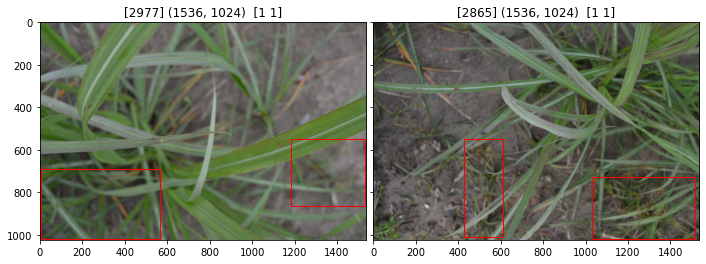

In [24]:
# Plot example batch
plot_batch_labels(inputs, targets)

In [25]:
# def vis_detections(im, class_name, dets, thresh=0.5):
#     """Draw detected bounding boxes."""
#     inds = np.where(dets[:, -1] >= thresh)[0]
#     if len(inds) == 0:
#         return

#     im = im[:, :, (2, 1, 0)]
#     fig, ax = plt.subplots(figsize=(12, 12))
#     ax.imshow(im, aspect='equal')
#     for i in inds:
#         bbox = dets[i, :4]
#         score = dets[i, -1]

#         ax.add_patch(
#             plt.Rectangle((bbox[0], bbox[1]),
#                           bbox[2] - bbox[0],
#                           bbox[3] - bbox[1],
#                           fill=False,
#                           edgecolor='red',
#                           linewidth=3.5))
#         ax.text(
#             bbox[0],
#             bbox[1] - 2,
#             '{:s} {:.3f}'.format(class_name, score),
#             bbox=dict(facecolor='blue', alpha=0.5),
#             fontsize=14,
#             color='white')

#     ax.set_title(
#         ('{} detections with '
#          'p({} | box) >= {:.1f}').format(class_name, class_name, thresh),
#         fontsize=14)
#     plt.axis('off')
#     plt.tight_layout()
#     plt.draw()
    

In [26]:
# TODO - fix - get the model using our helper function
model = get_model_fastrcnn_base(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [  0/100]  eta: 0:04:30  lr: 0.000055  loss: 1.2598 (1.2598)  loss_classifier: 0.8209 (0.8209)  loss_box_reg: 0.0937 (0.0937)  loss_objectness: 0.2696 (0.2696)  loss_rpn_box_reg: 0.0756 (0.0756)  time: 2.7048  data: 1.8710  max mem: 3968
Epoch: [0]  [ 10/100]  eta: 0:01:12  lr: 0.000560  loss: 0.9416 (0.9943)  loss_classifier: 0.5251 (0.4979)  loss_box_reg: 0.1415 (0.2000)  loss_objectness: 0.2045 (0.2134)  loss_rpn_box_reg: 0.0864 (0.0830)  time: 0.8025  data: 0.1828  max mem: 4236
Epoch: [0]  [ 20/100]  eta: 0:01:00  lr: 0.001065  loss: 0.6683 (0.8160)  loss_classifier: 0.2829 (0.3893)  loss_box_reg: 0.1761 (0.1923)  loss_objectness: 0.0805 (0.1555)  loss_rpn_box_reg: 0.0767 (0.0790)  time: 0.6565  data: 0.0128  max mem: 4236
Epoch: [0]  [ 30/100]  eta: 0:00:51  lr: 0.001569  loss: 0.4793 (0.6874)  loss_classifier: 0.2129 (0.3209)  loss_box_reg: 0.1442 (0.1741)  loss_objectness: 0.0587 (0.1180)  loss_rpn_box_reg: 0.0663 (0.0743)  time: 0.7068  data: 0.0114  max mem: 4236


Epoch: [2]  [  0/100]  eta: 0:04:39  lr: 0.005000  loss: 0.2100 (0.2100)  loss_classifier: 0.0838 (0.0838)  loss_box_reg: 0.0635 (0.0635)  loss_objectness: 0.0113 (0.0113)  loss_rpn_box_reg: 0.0514 (0.0514)  time: 2.7937  data: 1.9101  max mem: 4237
Epoch: [2]  [ 10/100]  eta: 0:01:16  lr: 0.005000  loss: 0.2870 (0.3549)  loss_classifier: 0.1610 (0.1549)  loss_box_reg: 0.1053 (0.1306)  loss_objectness: 0.0128 (0.0160)  loss_rpn_box_reg: 0.0514 (0.0533)  time: 0.8509  data: 0.1891  max mem: 4237
Epoch: [2]  [ 20/100]  eta: 0:01:02  lr: 0.005000  loss: 0.4316 (0.4127)  loss_classifier: 0.1854 (0.1821)  loss_box_reg: 0.1532 (0.1596)  loss_objectness: 0.0145 (0.0187)  loss_rpn_box_reg: 0.0384 (0.0522)  time: 0.6826  data: 0.0138  max mem: 4237
Epoch: [2]  [ 30/100]  eta: 0:00:52  lr: 0.005000  loss: 0.4383 (0.4358)  loss_classifier: 0.1896 (0.1962)  loss_box_reg: 0.1751 (0.1681)  loss_objectness: 0.0184 (0.0199)  loss_rpn_box_reg: 0.0450 (0.0516)  time: 0.6993  data: 0.0108  max mem: 4237


Epoch: [4]  [  0/100]  eta: 0:04:02  lr: 0.000500  loss: 0.2342 (0.2342)  loss_classifier: 0.1066 (0.1066)  loss_box_reg: 0.0873 (0.0873)  loss_objectness: 0.0086 (0.0086)  loss_rpn_box_reg: 0.0317 (0.0317)  time: 2.4220  data: 1.7584  max mem: 4237
Epoch: [4]  [ 10/100]  eta: 0:01:18  lr: 0.000500  loss: 0.1652 (0.2047)  loss_classifier: 0.0717 (0.0813)  loss_box_reg: 0.0583 (0.0609)  loss_objectness: 0.0090 (0.0095)  loss_rpn_box_reg: 0.0509 (0.0530)  time: 0.8681  data: 0.1735  max mem: 4237
Epoch: [4]  [ 20/100]  eta: 0:01:00  lr: 0.000500  loss: 0.1942 (0.2602)  loss_classifier: 0.0738 (0.1083)  loss_box_reg: 0.0608 (0.0903)  loss_objectness: 0.0111 (0.0114)  loss_rpn_box_reg: 0.0486 (0.0501)  time: 0.6752  data: 0.0129  max mem: 4237
Epoch: [4]  [ 30/100]  eta: 0:00:49  lr: 0.000500  loss: 0.3078 (0.2698)  loss_classifier: 0.1139 (0.1142)  loss_box_reg: 0.1105 (0.0937)  loss_objectness: 0.0098 (0.0114)  loss_rpn_box_reg: 0.0486 (0.0505)  time: 0.6147  data: 0.0117  max mem: 4237


Epoch: [6]  [  0/100]  eta: 0:03:52  lr: 0.000050  loss: 0.1114 (0.1114)  loss_classifier: 0.0426 (0.0426)  loss_box_reg: 0.0309 (0.0309)  loss_objectness: 0.0063 (0.0063)  loss_rpn_box_reg: 0.0316 (0.0316)  time: 2.3260  data: 1.6978  max mem: 4237
Epoch: [6]  [ 10/100]  eta: 0:01:18  lr: 0.000050  loss: 0.1633 (0.1814)  loss_classifier: 0.0679 (0.0792)  loss_box_reg: 0.0476 (0.0537)  loss_objectness: 0.0067 (0.0097)  loss_rpn_box_reg: 0.0333 (0.0388)  time: 0.8777  data: 0.1732  max mem: 4237
Epoch: [6]  [ 20/100]  eta: 0:01:04  lr: 0.000050  loss: 0.1700 (0.2038)  loss_classifier: 0.0731 (0.0878)  loss_box_reg: 0.0602 (0.0685)  loss_objectness: 0.0067 (0.0087)  loss_rpn_box_reg: 0.0399 (0.0389)  time: 0.7301  data: 0.0153  max mem: 4237
Epoch: [6]  [ 30/100]  eta: 0:00:52  lr: 0.000050  loss: 0.2213 (0.2127)  loss_classifier: 0.0943 (0.0881)  loss_box_reg: 0.0842 (0.0736)  loss_objectness: 0.0085 (0.0095)  loss_rpn_box_reg: 0.0376 (0.0415)  time: 0.6832  data: 0.0102  max mem: 4237


Epoch: [8]  [  0/100]  eta: 0:04:18  lr: 0.000050  loss: 0.0719 (0.0719)  loss_classifier: 0.0265 (0.0265)  loss_box_reg: 0.0195 (0.0195)  loss_objectness: 0.0047 (0.0047)  loss_rpn_box_reg: 0.0212 (0.0212)  time: 2.5818  data: 1.7028  max mem: 4237
Epoch: [8]  [ 10/100]  eta: 0:01:12  lr: 0.000050  loss: 0.1527 (0.2157)  loss_classifier: 0.0563 (0.0844)  loss_box_reg: 0.0288 (0.0733)  loss_objectness: 0.0082 (0.0108)  loss_rpn_box_reg: 0.0462 (0.0472)  time: 0.8061  data: 0.1735  max mem: 4237
Epoch: [8]  [ 20/100]  eta: 0:01:00  lr: 0.000050  loss: 0.2353 (0.2214)  loss_classifier: 0.0944 (0.0914)  loss_box_reg: 0.0873 (0.0782)  loss_objectness: 0.0082 (0.0094)  loss_rpn_box_reg: 0.0409 (0.0425)  time: 0.6698  data: 0.0154  max mem: 4237
Epoch: [8]  [ 30/100]  eta: 0:00:51  lr: 0.000050  loss: 0.2348 (0.2190)  loss_classifier: 0.0944 (0.0907)  loss_box_reg: 0.0850 (0.0756)  loss_objectness: 0.0084 (0.0091)  loss_rpn_box_reg: 0.0349 (0.0436)  time: 0.7026  data: 0.0100  max mem: 4237


In [27]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)